
# Dataset y consigna del TP


Descargar el dataset **Global Climate Change Data** https://data.world/data-society/global-climate-change-data

<ul>
<li>Graficar una serie a partir de un dataset relevante. Describir observaciones.</li>
<li> Descomponer una serie de tiempo usando el modelo aditivo de cuatro componentes. </li>
<li> Extraer la tendencia y ajustar un modelo determinístico. Explicar su relación con el
contexto. Obtener conclusiones acerca de la validez del modelo. </li>
<li> <b> Entrega clase 4: </b> Evaluar si la serie original es estacionaria. Aplicar transformaciones
(preprocesamiento), graficar autocorrelación, autocorrelación parcial y extraer
conclusiones.
<li> <b>Entrega clase 6:</b> A partir de las transformaciones propuestas ajustar distintos modelos
(S)ARIMA. Extraer orden, parámetros, coeficientes numéricos y análisis de la bondad
del modelo.
<li> Ajustar y predecir usando redes neuronales LSTM. Comparar con predicciones
usando SARIMA y extraer conclusiones. </li>
<li> Reailzar el análisis espectral de la serie original. Hallar las frecuencias principales y
comparar con las componentes cíclica y estacional usando la descomposición. </li>
<li> <b> Entrega clase 8: </b> Presentación incluyendo introducción, gráficos, modelos propuestos,
expresiones analíticas y conclusiones. </li>

</ul>

# Importar librerías


In [40]:
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm

# Cargar datos
Cargar el dataset

In [66]:
from cmath import isnan


PATH_DATASET = "dataset-GlobalTemperatures.csv"

df = pd.read_csv(PATH_DATASET, delimiter=',')
df = df[['dt', 'LandAverageTemperature']]   # Extraigo solo columnas de interes
df = df.rename(columns={'LandAverageTemperature': 'temp'})

# Look at the dataset
# df.info()
print('\n Null count: \n', df.isnull().sum() )

# Hay 12 valores null en la temperatura. Imputo el promedio entre día anterior y posterior
nulls_index = df[df['temp'].isnull()].index.tolist()

for i in nulls_index:
    new_val = (df.at[i-1,'temp'] + df.at[i+1,'temp'])*0.5
    if(isnan(new_val) == True):   # Go backwards and find a valid value
        offset = 1
        prev_val = df.at[i-offset,'temp']
        while(isnan(prev_val)):
            offset += 1
            prev_val = df.at[i-offset,'temp']
        new_val = prev_val

    df.loc[i, 'temp'] = new_val
print('\n Null count after imputation: \n', df.isnull().sum() )
    
# Proceso columna de fecha para convertirla en datetime
df['dt'] = pd.to_datetime(df['dt'])
print(df.dtypes)

# Por último, seteo la fecha como indice del dataframe. Esto permite acceso cómodo
df = df.set_index('dt')

data = df.to_numpy().flatten()



 Null count: 
 dt       0
temp    12
dtype: int64

 Null count after imputation: 
 dt      0
temp    0
dtype: int64
dt      datetime64[ns]
temp           float64
dtype: object


In [42]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3192 entries, 1750-01-01 to 2015-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   temp    3184 non-null   float64
dtypes: float64(1)
memory usage: 178.9 KB
None


## Gráficos

<AxesSubplot:title={'center':'Daily Land temperature and Monthly median'}, xlabel='dt', ylabel='°C'>

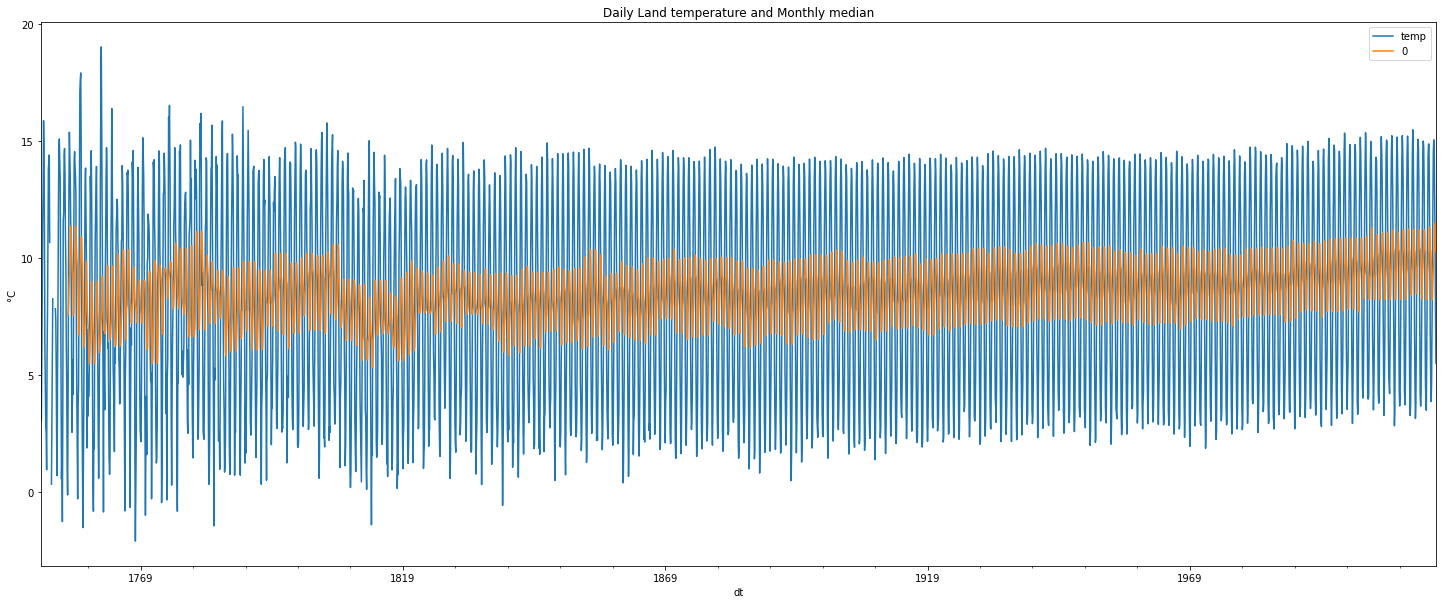

In [5]:
import pandas.core.window.rolling

myAx = df.plot(figsize=(25,10), title='Daily Land temperature and Monthly median', xlabel='year', ylabel='°C')

s = pd.Series(data).rolling(30).median()
median = pd.DataFrame(s).set_index(df.index)
median.plot(ax=myAx)

Se puede ver que la serie presenta muchas variaciones a lo largo de los 265 años que se registraron. Dado que son registros diarios, el gráfico se vuelve muy ruidoso. Por ello se graficó encima la mediana móvil de 30 días de muestras. Esta mediana muestra que la serie tiene una tendencia a aumentar, por lo que se puede pensar como que no es una serie estacionaria.<br>

<AxesSubplot:xlabel='dt'>

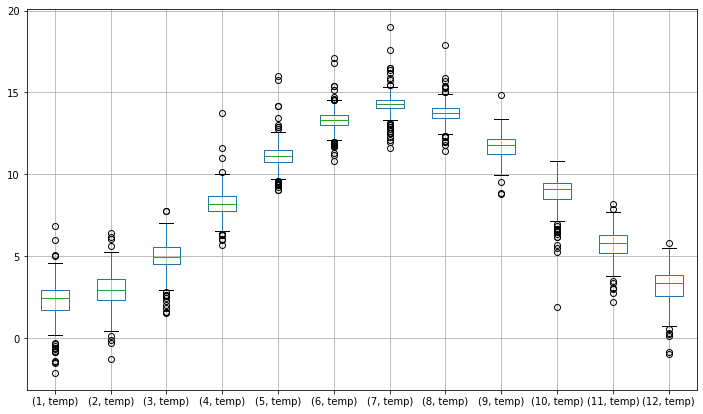

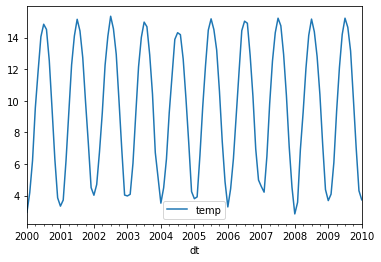

In [37]:
df.groupby(df.index.month).boxplot(subplots=False, sharex=True, figsize=(12,7))
df['1/1/2000':'1/1/2010'].plot()


Acá se puede ver la estacionalidad de la serie, que no se podía apreciar en el gráfico anterior debido a la cantidad de muestras. Acá se puede ver la estacionalidad de la serie a lo largo de un año. Estas variaciones se deben a la cercanía de la tierra con el sol a lo largo de un año

<AxesSubplot:title={'center':'Yearly variance land temperature'}, xlabel='year', ylabel='°C'>

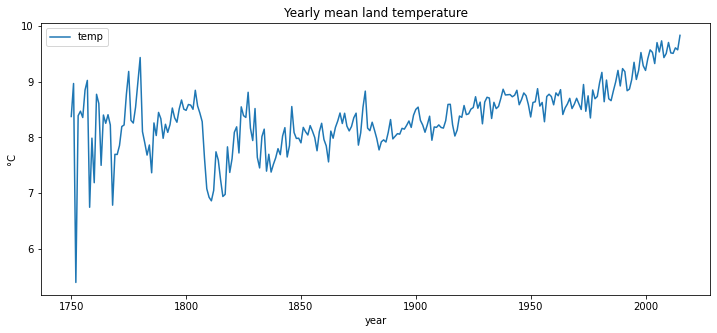

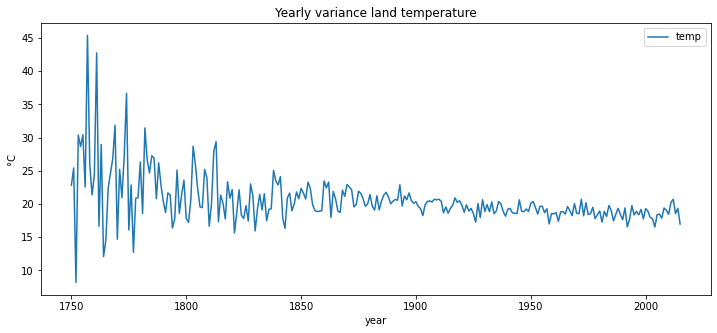

In [6]:
df.groupby(df.index.year).mean().plot(figsize=(12,5), title='Yearly mean land temperature', xlabel='year', ylabel='°C')
df.groupby(df.index.year).var().plot(figsize=(12,5), title='Yearly variance land temperature', xlabel='year', ylabel='°C')

El efecto de la tendencia se puede ver aún mejor si agrupamos los datos por año y calculamos el promedio anual de la temperatura. Con este gráfico se puede ver claramente que la temperatura global promedio anual tiene una tendencia a subir. Incluso se nota una gran aceleración en la escalada con un punto de inflexión significativo alrededor de los años 1960 y 1980.
Otro factor interesante se puede ver en la varianza de la temperatura anual. Se puede ver una disminución progresiva en la varianza, indicando que en cada año hay menor dispersión de los datos, manteniendo mayor uniformidad a lo largo de las distintas estaciones.
Cómo se propuso anteriormente, se puede ver claramente que la serie no es estacionaria, dado que la media y la varianza no se mantienen constantes a lo largo del tiempo.

# Descomposición del modelo

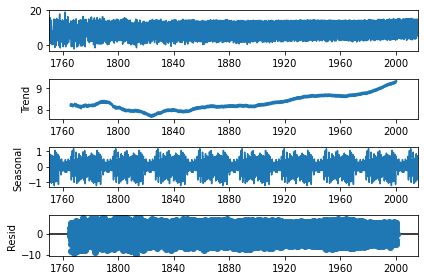

In [82]:
period=365
df_dec = sm.tsa.seasonal_decompose(df, model='additive', period=period)
dec_plt = df_dec.plot()


Text(0.5, 1.0, 'Series trend')

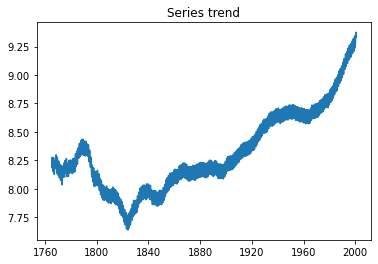

In [114]:
trend = df_dec._trend.dropna()  # Drop nans
plt.plot(trend)
plt.title('Series trend')

### Analisis autocorrelación

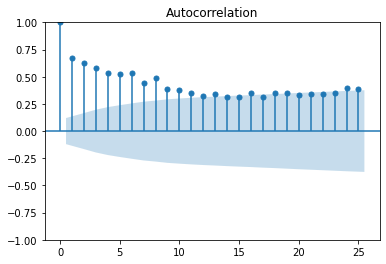

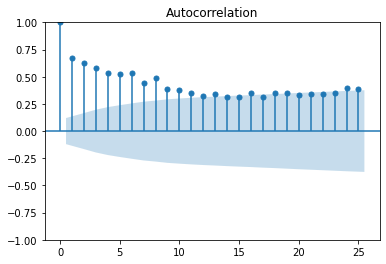

In [13]:
plot_acf(df.groupby(df.index.year).mean())